validationデータの用意
validation処理の追加

In [1]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Subsetを用いて、学習用画像60000枚を学習用50000枚と検証用10000枚に分割

In [3]:
train_size = 50000
train_indices = list(range(0,train_size))
valid_indices = list(range(train_size, len(training_data)))

train_data = Subset(training_data, train_indices)
valid_data = Subset(training_data, valid_indices)

print(len(train_data), len(valid_data))


50000 10000


In [4]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(train_data, batch_size=batch_size)
validation_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [8]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= size
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

validation損失をもとに最適epochを決定


In [10]:
epochs = 5
best_epoch = 0
min_loss = 1000
os.makedirs("./model/", exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), "./model/model_"+str(t+1)+".pth")
print(best_epoch)

model.load_state_dict(torch.load("model/model_"+str(best_epoch)+".pth"))
test(test_dataloader, model)

print("Done!")

Epoch 1
-------------------------------
loss: 2.303149  [    0/50000]
loss: 2.294225  [ 6400/50000]
loss: 2.278836  [12800/50000]
loss: 2.274691  [19200/50000]
loss: 2.257877  [25600/50000]
loss: 2.255650  [32000/50000]
loss: 2.262770  [38400/50000]
loss: 2.247452  [44800/50000]
Validation Error: 
 Accuracy: 44.6%, Avg loss: 0.035005 

Epoch 2
-------------------------------
loss: 2.259557  [    0/50000]
loss: 2.232162  [ 6400/50000]
loss: 2.206754  [12800/50000]
loss: 2.210886  [19200/50000]
loss: 2.149588  [25600/50000]
loss: 2.177650  [32000/50000]
loss: 2.194105  [38400/50000]
loss: 2.170035  [44800/50000]
Validation Error: 
 Accuracy: 46.8%, Avg loss: 0.033550 

Epoch 3
-------------------------------
loss: 2.195448  [    0/50000]
loss: 2.141971  [ 6400/50000]
loss: 2.104419  [12800/50000]
loss: 2.117418  [19200/50000]
loss: 1.989683  [25600/50000]
loss: 2.068409  [32000/50000]
loss: 2.094519  [38400/50000]
loss: 2.059632  [44800/50000]
Validation Error: 
 Accuracy: 47.0%, Avg los

損失グラフ作成

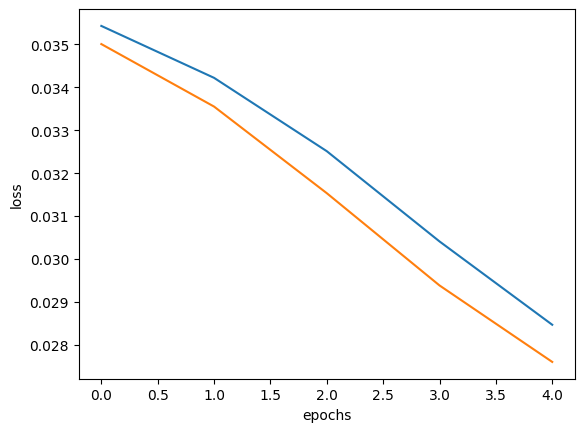

In [11]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
